# Merge E1 and E2

## Set up correct conda environment

In [2]:
.libPaths()

[1] "/home/users/xjluo/miniconda3/envs/jupyter_env/lib/R/library"

In [3]:
.libPaths('/home/groups/tttt/xjluo/miniconda3/envs/single_cell/lib/R/library')
.libPaths()

[1] "/home/groups/tttt/xjluo/miniconda3/envs/single_cell/lib/R/library"
[2] "/home/users/xjluo/miniconda3/envs/jupyter_env/lib/R/library"

## Load packages

In [4]:
library(tidyverse)
library(viridis)
library(Seurat)
library(Signac)
library(Azimuth)
library(EnsDb.Mmusculus.v79)
library(BSgenome.Mmusculus.UCSC.mm10)
library(ggpointdensity)
library(ggExtra)
library(GenomicRanges)

set.seed(1234)
options(repr.matrix.max.cols=100, repr.matrix.max.rows=50)
options(warn=-1)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: viridisLite

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, were retired in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.

Attaching SeuratObject

Registered S3 method overwritten by 'SeuratDisk'

In [5]:
sessionInfo()

R version 4.2.0 (2022-04-22)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/users/xjluo/miniconda3/envs/jupyter_env/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggExtra_0.10.1                     ggpointdensity_0.1.0              
 [3] BSgenome.Mmusculus.UCSC.mm10_1.4.3 BSgenome_1.66.3                   
 [5] rtracklayer_1.58.0                 Biostrings_2.66.0                 
 [7] XVector_0.38.0                     EnsDb.Mmuscu

# Sample

In [6]:
sample_name_merge <- 'E1_E2'

# Thresholds

In [7]:
# Di Bella & Habibi et al. 2021
# https://www.nature.com/articles/s41586-021-03670-5
# peak_region_fragments >3,000 & peak_region_fragments <100,000; pct_reads_in_peaks >40; blacklist_ratio <0.025 ; nucleosome_signal <4; TSS.enrichment >2

min_pct_frags_in_peaks <- 40
min_peak_region_fragments <- 6000
max_peak_region_fragments <- 100000
max_blacklist_ratio <- 0.025
max_nucleosome_signal <- 4
min_tss_enrich <- 2


# Paths

In [8]:
# step 1 outputs
step1_master_dir <- '/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step1_qc_OUTPUTS/filtered_objects'

step1_master_dir

[1] "/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step1_qc_OUTPUTS/filtered_objects"

In [9]:
# E1
E1_obj_path <- paste0(step1_master_dir, '/', 'E1.filtered.dev.azimuth.annotated.rds')

E1_obj_path

[1] "/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step1_qc_OUTPUTS/filtered_objects/E1.filtered.dev.azimuth.annotated.rds"

In [10]:
# E2
E2_obj_path <- paste0(step1_master_dir, '/', 'E2.filtered.dev.azimuth.annotated.rds')

E2_obj_path

[1] "/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step1_qc_OUTPUTS/filtered_objects/E2.filtered.dev.azimuth.annotated.rds"

In [11]:
# MACS outputs from step 1
macs_dir <- '/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step1_qc_OUTPUTS/macs3_outputs'

macs_dir

[1] "/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step1_qc_OUTPUTS/macs3_outputs"

In [12]:
# Output directory for this notebook (objects will be saved here)
outdir <- '/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step2_merge_OUTPUTS'

outdir

[1] "/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step2_merge_OUTPUTS"

In [13]:
# directory to output merged MACS peaks (this notebook, not step 1)
peaks_dir <- paste0(outdir, '/', 'peaks')

peaks_dir

[1] "/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step2_merge_OUTPUTS/peaks"

# Load E1 and E2 objects

In [14]:
# E1
e1_obj <- readRDS(E1_obj_path)

e1_obj

An object of class Seurat 
220317 features across 359 samples within 2 assays 
Active assay: ATAC (198509 features, 195163 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: lsi, umap

In [15]:
# E2
e2_obj <- readRDS(E1_obj_path)

e2_obj

An object of class Seurat 
220317 features across 359 samples within 2 assays 
Active assay: ATAC (198509 features, 195163 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: lsi, umap

In [16]:
# check dimensions of peak-cell matrices
dim(GetAssayData(e1_obj, assay = 'ATAC', slot = 'data'))
dim(GetAssayData(e2_obj, assay = 'ATAC', slot = 'data'))


[1] 198509    359

[1] 198509    359

In [81]:
# get gene annotations for mm10
annotation <- GetGRangesFromEnsDb(ensdb = EnsDb.Mmusculus.v79)
seqlevelsStyle(annotation) <- "UCSC"

# Get sample names

In [18]:
samples <- c('E1', 'E2')

# Merge ATAC peaks across wells

## The procedure:

### 1) Concatenate peak files from E1 and E2

### 2) Truncate peaks in concatenated peak file to 200bp

### 3) GenomicRanges::reduce (same as default 'bedtools merge') the truncated peaks generated from 2)

### 4) Generate a peak-cell fragment counts matrix using bedtools merged peaks generated from 3)

https://stuartlab.org/signac/articles/merging.html#creating-a-common-peak-set

## Load ATAC samples

In [19]:
addr_dict <- list()
bad_samples <- c('')

for (sample in samples) {
    if (!(sample %in% bad_samples)) {
        if (!(sample %in% names(addr_dict))) {
            print(sample)
            flush.console()
            addr_dict[[sample]] <- paste0(step1_master_dir, '/', sample, '.filtered.dev.azimuth.annotated.rds')
        }
    }
}

[1] "E1"
[1] "E2"


In [20]:
addr_dict
length(addr_dict)

$E1
[1] "/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step1_qc_OUTPUTS/filtered_objects/E1.filtered.dev.azimuth.annotated.rds"

$E2
[1] "/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step1_qc_OUTPUTS/filtered_objects/E2.filtered.dev.azimuth.annotated.rds"

[1] 2

In [21]:
# Get peaks-only Seurat objects for each 
peaks_rds_dict <- list()

for (sample in samples) {
    print(sample)
    flush.console()
    peaks_rds_dict[[sample]] <- readRDS(file = addr_dict[[sample]])
    DefaultAssay(peaks_rds_dict[[sample]]) <- "ATAC"
    peaks_rds_dict[[sample]][['lsi']] <- NULL
    peaks_rds_dict[[sample]][['umap']] <- NULL
    peaks_rds_dict[[sample]][['RNA']] <- NULL
}
     

[1] "E1"
[1] "E2"


In [22]:
peaks_rds_dict
length(peaks_rds_dict)

$E1
An object of class Seurat 
198509 features across 359 samples within 1 assay 
Active assay: ATAC (198509 features, 195163 variable features)

$E2
An object of class Seurat 
212211 features across 359 samples within 1 assay 
Active assay: ATAC (212211 features, 208269 variable features)


[1] 2

## Step 1

In [23]:
# Put narrowPeak files in a fresh folder 'peaks_dir' (and rename w/ well number)

granges_dict <- list()

for (sample in samples) {
    print(sample)
    flush.console()
    granges_dict[[sample]] <- granges(peaks_rds_dict[[sample]])
    system(paste("cp",    
             paste0(macs_dir, "/", sample, "/SeuratProject_peaks.narrowPeak"),
             paste0(peaks_dir, "/", sample, ".peaks.bed")), intern=TRUE)
}

[1] "E1"
[1] "E2"


In [24]:
# Run linux 'cat' to concatenate BED files
# https://unix.stackexchange.com/questions/337993/how-to-merge-text-file-vertically
system(paste("cat",    
             paste0(peaks_dir, "/", "*.peaks.bed"),
            ">",
            paste0(peaks_dir, "/", sample_name_merge, ".peaks.concat.bed")), intern=TRUE)

character(0)

## Step 2

In [25]:
step2_cmd <- paste("python3",
             "truncate_merged_peak_file_around_summit.py",
             "--input_bed", paste0(peaks_dir, "/", sample_name_merge, ".peaks.concat.bed"),
             "--summit_flank", "100",
             "--outf", paste0(peaks_dir, "/", sample_name_merge, '.peaks.concat.200bp.bed')
             )

step2_cmd

[1] "python3 truncate_merged_peak_file_around_summit.py --input_bed /oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step2_merge_OUTPUTS/peaks/E1_E2.peaks.concat.bed --summit_flank 100 --outf /oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step2_merge_OUTPUTS/peaks/E1_E2.peaks.concat.200bp.bed"

In [26]:
# Run the above from command line
# system(step2_cmd, intern=TRUE)

In [27]:
# Check truncated peaks

concat_truncated_peaks <- read.table(paste0(peaks_dir, "/", sample_name_merge, '.peaks.concat.200bp.bed'),
                           sep='\t')
concat_truncated_peaks_df <- data.frame(concat_truncated_peaks)
colnames(concat_truncated_peaks_df) <- c("seqnames", 
                                         "start", 
                                         "end",
                                        "name",
                                        "score",
                                        "strand",
                                        "signalValue",
                                        "pValue",
                                        "qValue",
                                        "peak")    # https://genome.ucsc.edu/FAQ/FAQformat.html#format12

head(concat_truncated_peaks_df)
dim(concat_truncated_peaks_df)

,seqnames,start,end,name,score,strand,signalValue,pValue,qValue,peak
,<chr>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<int>
1,chr1,3113651,3113851,SeuratProject_peak_1,649,.,19.6554,64.9050,62.3402,100
2,chr1,3113665,3113865,SeuratProject_peak_1,362,.,12.7163,36.2326,33.8899,100
3,chr1,3119913,3120113,SeuratProject_peak_2a,1030,.,26.9834,103.0740,100.3190,100
4,chr1,3119931,3120131,SeuratProject_peak_2a,1182,.,30.6109,118.2390,115.4170,100
5,chr1,3120386,3120586,SeuratProject_peak_2b,2889,.,59.2394,288.9170,285.5910,100
6,chr1,3120401,3120601,SeuratProject_peak_2b,1931,.,44.4664,193.1820,190.1080,100


[1] 518181     10

## Step 3

In [28]:
bedtools_path <- '~/miniconda3/envs/jupyter_env/bin/bedtools'

In [29]:
# Merge truncated peaks using bedtools
# https://bedtools.readthedocs.io/en/latest/content/tools/merge.html
step3_cmd <- paste(bedtools_path, "merge",
             "-i", paste0(peaks_dir, '/', sample_name_merge, '.peaks.concat.200bp.bed'),
             ">", paste0(peaks_dir, '/', sample_name_merge, '.peaks.concat.merged.200bp.bed')
             )

step3_cmd

[1] "~/miniconda3/envs/jupyter_env/bin/bedtools merge -i /oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step2_merge_OUTPUTS/peaks/E1_E2.peaks.concat.200bp.bed > /oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step2_merge_OUTPUTS/peaks/E1_E2.peaks.concat.merged.200bp.bed"

In [30]:
system(step3_cmd, intern=TRUE)
print('Done')

character(0)

[1] "Done"


In [31]:
# Check truncated and merged peaks

concat_truncated_merged_peaks <- read.table(paste0(peaks_dir, '/', sample_name_merge, '.peaks.concat.merged.200bp.bed'),
                           sep='\t')
concat_truncated_merged_peaks_df <- data.frame(concat_truncated_merged_peaks)
colnames(concat_truncated_merged_peaks_df) <- c("chrom", "start", "end")

head(concat_truncated_merged_peaks_df)
dim(concat_truncated_merged_peaks_df)

,chrom,start,end
,<chr>,<int>,<int>
1,chr1,3113651,3113865
2,chr1,3119913,3120131
3,chr1,3120386,3120601
4,chr1,3121379,3121601
5,chr1,3121683,3121883
6,chr1,3130084,3130329


[1] 313874      3

## Step 4
### Get ATAC RDS files containing fragment counts matrix for all consensus (i.e. truncated/merged peaks from step 3) peaks for each replicate (since each replicate has its own fragments file)

In [38]:
merged_dir <- paste0(outdir, "/merged_peaks")

merged_dir

[1] "/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step2_merge_OUTPUTS/merged_peaks"

In [33]:
for (sample in samples) {
print(sample)

addr <- paste0(step1_master_dir, '/', sample, '.filtered.dev.azimuth.annotated.rds')
peaks_rds <- readRDS(file = addr)

DefaultAssay(peaks_rds) <- "ATAC"
peaks_rds[['lsi']] <- NULL
peaks_rds[['umap']] <- NULL
peaks_rds[['RNA']] <- NULL
    

peaks_df <- read.table(
  file = paste0(peaks_dir, '/', sample_name_merge, '.peaks.concat.merged.200bp.bed'),
  col.names = c("chrom", "start", "end")
)

peaks <- makeGRangesFromDataFrame(peaks_df)

print(Fragments(peaks_rds))
print(Fragments(peaks_rds)[[1]]@path)
    
counts <- FeatureMatrix(fragments = Fragments(peaks_rds),
                        features = peaks,
                        cells = colnames(peaks_rds)
                       )

assay <- CreateChromatinAssay(counts, fragments=Fragments(peaks_rds))
object <- CreateSeuratObject(assay, assay="peaks", meta.data=peaks_rds@meta.data)

saveRDS(object, file = paste0(outdir, "/merged_peaks/", sample, ".final.peak.counts.rds"))

}

[1] "E1"
[[1]]
A Fragment object for 359 cells

[1] "/oak/stanford/groups/tttt/collaboration/jin/231003_ATAC/cellranger/output/E1_outs/fragments.tsv.gz"


Extracting reads overlapping genomic regions



[1] "E2"
[[1]]
A Fragment object for 359 cells

[1] "/oak/stanford/groups/tttt/collaboration/jin/231003_ATAC/cellranger/output/E2_outs/fragments.tsv.gz"


Extracting reads overlapping genomic regions



## Merge ATAC RDS files

In [39]:
merged_peaks_addr_dict <- list()
merged_peaks_rds_dict <- list()

for (sample in samples) {
    print(sample)
    merged_peaks_addr_dict[[sample]] <- paste0(merged_dir, '/', sample, '.final.peak.counts.rds')
    merged_peaks_rds_dict[[sample]] <- readRDS(file = merged_peaks_addr_dict[[sample]])
}

merged_peaks_rds_dict

[1] "E1"
[1] "E2"


$E1
An object of class Seurat 
313874 features across 359 samples within 1 assay 
Active assay: peaks (313874 features, 0 variable features)

$E2
An object of class Seurat 
313874 features across 359 samples within 1 assay 
Active assay: peaks (313874 features, 0 variable features)


In [40]:
all_merged_peaks_objects <- list.files(paste0(merged_dir))
all_merged_peaks_objects

[1] "E1.final.peak.counts.rds" "E2.final.peak.counts.rds"

In [41]:
merged_peaks_samples <- unlist(lapply(all_merged_peaks_objects,  sub, pattern = ".final.peak.counts.rds$", replacement = ""))

merged_peaks_samples

[1] "E1" "E2"

In [42]:
# merge
merged.e1.e2.atac.obj <- merge(unname(unlist(merged_peaks_rds_dict))[[1]],
                               y = unname(unlist(merged_peaks_rds_dict))[-1],
                               add.cell.ids = names(merged_peaks_rds_dict)
                                )

merged.e1.e2.atac.obj

An object of class Seurat 
313874 features across 718 samples within 1 assay 
Active assay: peaks (313874 features, 0 variable features)

In [43]:
# check uniqueness of cell barcodes
length(unique(Cells(merged.e1.e2.atac.obj))) == length(Cells(merged.e1.e2.atac.obj))

[1] TRUE

In [44]:
head(merged.e1.e2.atac.obj@meta.data)
dim(merged.e1.e2.atac.obj@meta.data)

,orig.ident,nCount_peaks,nFeature_peaks,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,nonprimary,passed_filters,is__cell_barcode,excluded_reason,TSS_fragments,DNase_sensitive_region_fragments,enhancer_region_fragments,promoter_region_fragments,on_target_fragments,blacklist_region_fragments,peak_region_fragments,peak_region_cutsites,nucleosome_signal,nucleosome_percentile,TSS.enrichment,TSS.percentile,pct_frags_in_peaks,blacklist_ratio,ATAC_snn_res.1.2,seurat_clusters,nCount_RNA,nFeature_RNA,predicted.id.dev,prediction.score.Layer.4,prediction.score.Endothelial.cells,prediction.score.Astrocytes,prediction.score.Immature.neurons,prediction.score.UL.CPN,prediction.score.Interneurons,prediction.score.CThPN,prediction.score.DL_CPN_1,prediction.score.NP,prediction.score.Oligodendrocytes,prediction.score.Cycling.glial.cells,prediction.score.DL_CPN_2,prediction.score.SCPN,prediction.score.Migrating.neurons,prediction.score.Pericytes,prediction.score.Microglia,prediction.score.Cajal.Retzius.cells,prediction.score.Layer.6b,prediction.score.max,predicted.id,prediction.score.Lamp5,prediction.score.Sncg,prediction.score.Vip,prediction.score.Sst.Chodl,prediction.score.L2.IT.RHP,prediction.score.Sst,prediction.score.Pvalb,prediction.score.L2.3.IT.CTX.2,prediction.score.L4.5.IT.CTX,prediction.score.L5.IT.CTX,prediction.score.L5.PT.CTX,prediction.score.L5.NP.CTX,prediction.score.L6b.CTX,prediction.score.Car3,prediction.score.CR,prediction.score.Oligo,prediction.score.Astro,prediction.score.SMC.Peri,prediction.score.Endo,prediction.score.VLMC,prediction.score.Micro.PVM,prediction.score.L6.IT.CTX,prediction.score.L6.CT.CTX,prediction.score.L2.3.IT.CTX.1,prediction.score.L3.RSP.ACA,prediction.score.L5.IT.TPE.ENT,prediction.score.L2.3.IT.PPP
,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
E1_AAACGAAAGGATTGAT-1,SeuratProject,15804,13844,26090,10866,40382,16311,1,438,1270,2,3,22357,1,0,6560,0,0,0,6560,0,13381,26090,0.5550485,0.43,7.148912,0.79,59.85150,0,0,0,13963,7418,UL CPN,0.2035296,0,0.004371554,0.07797900,0.2491261,0.09697844,0.000000000,0.15031223,0,0.096324081,0.12137896,0.00000000,0,0.0000000,0,0,0,0,0.2408574,L5 PT CTX,0.045097753,0.00000000,0.10401551,0.14095001,0,0.009870497,0.0000000,0.006033890,0.013959626,0.04724760,0.24085742,0.08270831,0.01356087,0.005550047,0.008236004,0.003082633,0.00000000,0.00000000,0.16781011,0,0.0000000,0.06139938,0.000000000,0.04962035,0,0,0
E1_AAAGATGCAGATAAGT-1,SeuratProject,26049,21610,42668,16150,76487,31387,4,953,2790,11,7,41335,1,0,11651,0,0,0,11651,0,22038,42668,0.7227480,0.92,6.796629,0.70,53.31559,0,3,3,24897,10139,Immature neurons,0.1170761,0,0.095795089,0.22666854,0.1432705,0.22255344,0.002798875,0.14146571,0,0.036623232,0.01374851,0.00000000,0,0.0000000,0,0,0,0,0.2208887,Micro-PVM,0.025170356,0.08920283,0.02600066,0.02319330,0,0.000000000,0.0000000,0.035842898,0.008727958,0.06602697,0.00000000,0.02001362,0.00000000,0.202222567,0.000000000,0.073842695,0.05139671,0.00000000,0.00000000,0,0.2208887,0.02732490,0.015657459,0.11448834,0,0,0
E1_AAAGGGCTCCAACCTC-1,SeuratProject,16684,14645,27791,11600,42865,13922,2,505,1693,14,3,26726,1,0,7307,0,0,0,7307,0,14302,27791,0.5539568,0.42,7.891713,0.92,53.51343,0,0,0,15995,8047,Layer 4,0.2769940,0,0.108860594,0.07912036,0.2541278,0.07198044,0.003226384,0.01794825,0,0.006436344,0.16749619,0.01380958,0,0.0000000,0,0,0,0,0.1824862,L5 IT CTX,0.141006786,0.00000000,0.03574444,0.03071390,0,0.010091801,0.1259147,0.005245702,0.052625031,0.18248621,0.12527229,0.08456931,0.02435388,0.000000000,0.000000000,0

[1] 718  81

In [45]:
head(GetAssayData(merged.e1.e2.atac.obj, assay = 'peaks', slot = 'data'))
dim(GetAssayData(merged.e1.e2.atac.obj, assay = 'peaks', slot = 'data'))

  [[ suppressing 718 column names 'E1_AAACGAAAGGATTGAT-1', 'E1_AAAGATGCAGATAAGT-1', 'E1_AAAGGGCTCCAACCTC-1' ... ]]



6 x 718 sparse Matrix of class "dgCMatrix"
                                                                              
chr1-3113651-3113865 . . . . . . . . . . . . . . . . . 1 . . . . . 1 . 1 . 2 .
chr1-3119913-3120131 . 2 . . . 1 . . . . . . . . 1 3 . . . 1 . . . 1 . . . . .
chr1-3120386-3120601 . . 1 . . 1 . 1 . 2 . . . . . . . . . . . 2 . . . 3 . . .
chr1-3121379-3121601 . . . . 1 . . . . . . . . . . . . . . . . 1 . . 1 . . . .
chr1-3121683-3121883 . . . . . . . . . . . . . . . . . . . . . 1 . . . . . . .
chr1-3130084-3130329 . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
                                                                              
chr1-3113651-3113865 . . . 2 . . . . . . . . . . . . . . . . . . . . . . . . .
chr1-3119913-3120131 1 . . . . . . . . . 1 . 1 . . . . . . . 1 . . . . . . . .
chr1-3120386-3120601 . 1 1 1 . . 1 1 . . . . . . . . . . . . 1 . 1 . . . 1 1 .
chr1-3121379-3121601 . . . . 1 . . 1 . . . . 1 . 1 . . . . . . . . . . . . . .
chr1-3121

[1] 313874    718

# Create ATAC object

# Run SVD

In [46]:
# renaming
filtered <- merged.e1.e2.atac.obj

rm(merged.e1.e2.atac.obj)

In [47]:
DefaultAssay(filtered) <- "peaks"

filtered <- FindTopFeatures(filtered, min.cutoff = 5)
filtered <- RunTFIDF(filtered)
filtered <- RunSVD(filtered)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



An object of class Seurat 
313874 features across 718 samples within 1 assay 
Active assay: peaks (313874 features, 313744 variable features)
 1 dimensional reduction calculated: lsi

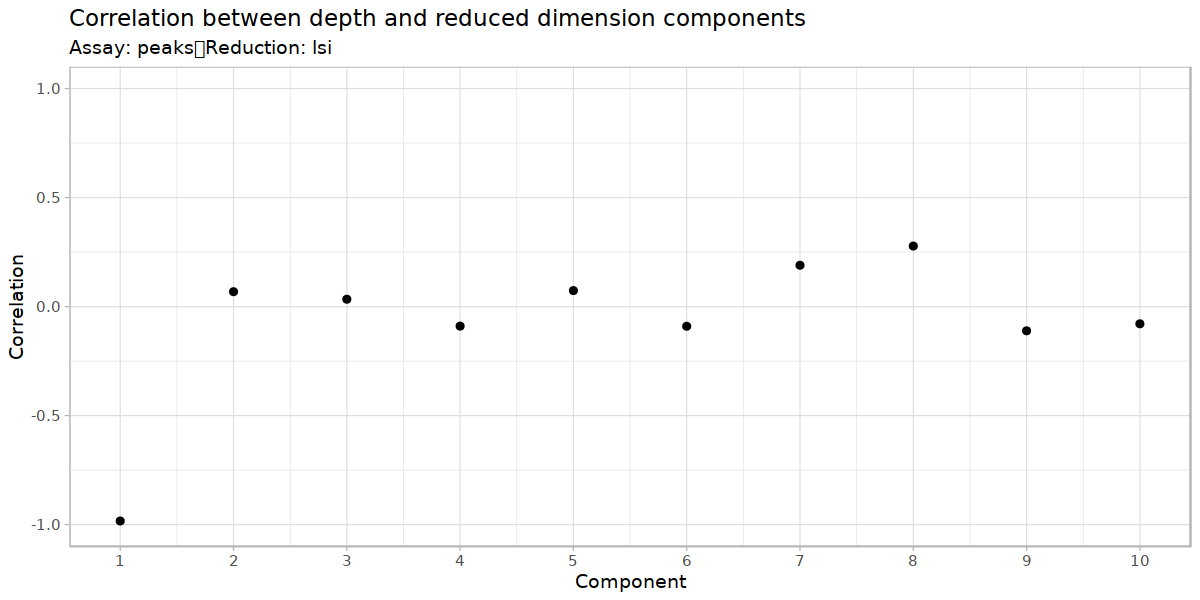

In [48]:
options(repr.plot.width=10, repr.plot.height=5)
DepthCor(filtered)
filtered

# Get ATAC-only UMAP and ATAC clusters

In [49]:
filtered <- RunUMAP(
  object = filtered,
  reduction = 'lsi',
  dims = 2:30
)

filtered

20:52:37 UMAP embedding parameters a = 0.9922 b = 1.112

20:52:37 Read 718 rows and found 29 numeric columns

20:52:37 Using Annoy for neighbor search, n_neighbors = 30

20:52:37 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:52:37 Writing NN index file to temp file /tmp/RtmpAV3adY/fileb0d95e8023f6

20:52:37 Searching Annoy index using 1 thread, search_k = 3000

20:52:37 Annoy recall = 100%

20:52:39 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

20:52:41 Initializing from normalized Laplacian + noise (using irlba)

20:52:41 Commencing optimization for 500 epochs, with 26366 positive edges

20:52:44 Optimization finished



An object of class Seurat 
313874 features across 718 samples within 1 assay 
Active assay: peaks (313874 features, 313744 variable features)
 2 dimensional reductions calculated: lsi, umap

In [50]:
filtered <- FindNeighbors(
  object = filtered,
  reduction = 'lsi',
  dims = 2:30
)

filtered

Computing nearest neighbor graph

Computing SNN



An object of class Seurat 
313874 features across 718 samples within 1 assay 
Active assay: peaks (313874 features, 313744 variable features)
 2 dimensional reductions calculated: lsi, umap

In [51]:
filtered <- FindClusters(
  object = filtered,
  algorithm = 3,
  resolution = 1.2,
  verbose = FALSE
)

filtered

An object of class Seurat 
313874 features across 718 samples within 1 assay 
Active assay: peaks (313874 features, 313744 variable features)
 2 dimensional reductions calculated: lsi, umap

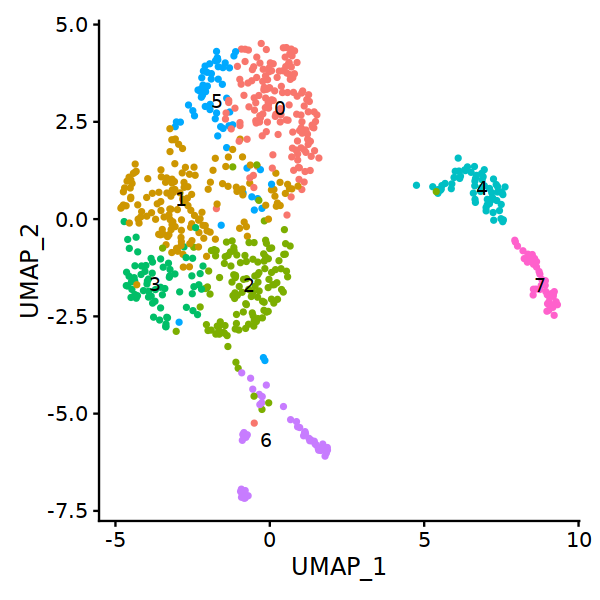

In [52]:
options(repr.plot.width=5, repr.plot.height=5)

DimPlot(object = filtered, label = TRUE) + NoLegend()

# Anchor to published RNA data
P4 scRNA-seq from https://www.nature.com/articles/s41586-021-03670-5

## Load data

In [53]:
rna_counts_all_path = '/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/dibella_habibi_data/SCP1290/expression/601ae2f4771a5b0d72588bfb'
rna_counts_all_path

[1] "/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/dibella_habibi_data/SCP1290/expression/601ae2f4771a5b0d72588bfb"

In [54]:
rna_counts_all <- Read10X(rna_counts_all_path)

In [55]:
head(colnames(rna_counts_all))
dim(rna_counts_all)

[1] "E10_v1_AAACCTGAGGGTCTCC-1" "E10_v1_AAACCTGCACAACGCC-1"
[3] "E10_v1_AAACCTGCACGACGAA-1" "E10_v1_AAACCTGCAGACAAGC-1"
[5] "E10_v1_AAACCTGCAGAGCCAA-1" "E10_v1_AAACCTGGTGGCCCTA-1"

[1] 19712 98047

In [56]:
table(str_split_i(colnames(rna_counts_all), '_', 1))


  E10   E11   E12   E13   E14   E15   E16   E17   E18    P1    P4 
 2989  4221  9348  8907  5249 11670  5761  9381 20275 13072  7174 

## Create scRNA object

### Load metadata

In [57]:
rna_meta_path = '/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/dibella_habibi_data/SCP1290/metadata/metaData_scDevSC.txt'

rna_meta <- read.csv(
  file = rna_meta_path,
  header = TRUE,
  row.names = 1,
  sep='\t'
)

# http://www.sthda.com/english/wiki/reading-data-from-txt-csv-files-r-base-functions

In [58]:
rna_meta = rna_meta[-1,]
# https://stackoverflow.com/questions/7541610/how-to-delete-the-first-row-of-a-dataframe-in-r

In [59]:
head(rna_meta)
dim(rna_meta)

,orig_ident,nCount_RNA,nFeature_RNA,percent_mito,n_hkgene,S_Score,G2M_Score,Phase,CC_Difference,seurat_clusters,RNA_snn_res_1,scrublet_doublet,RNA_snn_res_2,Doublet_intersect,Gral_cellType,New_cellType,biosample_id,donor_id,species,disease,disease__ontology_label,organ,organ__ontology_label,library_preparation_protocol,library_preparation_protocol__ontology_label,sex,species__ontology_label
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
E10_v1_AAACCTGAGGGTCTCC-1,E10,1544,1022,0.02007772,51,0.356987282,0.330795055,S,0.026192226,34,20,FALSE,34,NA,NA,Apical progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGCACAACGCC-1,E10,1157,783,0.014693172,39,0.453853807,0.260559945,S,0.193293862,34,20,FALSE,34,NA,NA,Intermediate progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGCACGACGAA-1,E10,2081,1200,0.016338299,67,0.447598221,0.218745871,S,0.228852351,34,20,FALSE,34,NA,NA,Apical progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGCAGACAAGC-1,E10,2490,1430,0.021285141,71,0.227723147,0.307101877,G2M,-0.079378731,37,20,FALSE,37,NA,NA,Apical progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGCAGAGCCAA-1,E10,2514,1416,0.021081941,70,0.738406445,0.136556035,S,0.601850411,37,20,FALSE,37,NA,NA,Apical progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGGTGGCCCTA-1,E10,1009,692,0.026759167,50,0.565625946,0.094001224,S,0.471624722,34,20,FALSE,34,NA,NA,Apical progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus


[1] 98047    27

In [60]:
colnames(rna_meta)

[1] "orig_ident"                                  
 [2] "nCount_RNA"                                  
 [3] "nFeature_RNA"                                
 [4] "percent_mito"                                
 [5] "n_hkgene"                                    
 [6] "S_Score"                                     
 [7] "G2M_Score"                                   
 [8] "Phase"                                       
 [9] "CC_Difference"                               
[10] "seurat_clusters"                             
[11] "RNA_snn_res_1"                               
[12] "scrublet_doublet"                            
[13] "RNA_snn_res_2"                               
[14] "Doublet_intersect"                           
[15] "Gral_cellType"                               
[16] "New_cellType"                                
[17] "biosample_id"                                
[18] "donor_id"                                    
[19] "species"                                     
[20] "disease"                                     
[21] "disease__ontology_label"                     
[22] "organ"                                       
[23] "organ__ontology_label"                       
[24] "library_preparation_protocol"                
[25] "library_preparation_protocol__ontology_label"
[26] "sex"                                         
[27] "species__ontology_label"

In [61]:
# cutoffs set in the paper
# section "scRNA-seq pre-processing, initial analysis and clustering"

max(rna_meta$percent_mito)
min(rna_meta$nCount_RNA)

[1] "0.074982481"

[1] "1000"

In [62]:
table(rna_meta$Doublet_intersect)


Doublet Singlet 
   1877   76626 

In [63]:
head(rna_meta)
dim(rna_meta)

,orig_ident,nCount_RNA,nFeature_RNA,percent_mito,n_hkgene,S_Score,G2M_Score,Phase,CC_Difference,seurat_clusters,RNA_snn_res_1,scrublet_doublet,RNA_snn_res_2,Doublet_intersect,Gral_cellType,New_cellType,biosample_id,donor_id,species,disease,disease__ontology_label,organ,organ__ontology_label,library_preparation_protocol,library_preparation_protocol__ontology_label,sex,species__ontology_label
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
E10_v1_AAACCTGAGGGTCTCC-1,E10,1544,1022,0.02007772,51,0.356987282,0.330795055,S,0.026192226,34,20,FALSE,34,NA,NA,Apical progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGCACAACGCC-1,E10,1157,783,0.014693172,39,0.453853807,0.260559945,S,0.193293862,34,20,FALSE,34,NA,NA,Intermediate progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGCACGACGAA-1,E10,2081,1200,0.016338299,67,0.447598221,0.218745871,S,0.228852351,34,20,FALSE,34,NA,NA,Apical progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGCAGACAAGC-1,E10,2490,1430,0.021285141,71,0.227723147,0.307101877,G2M,-0.079378731,37,20,FALSE,37,NA,NA,Apical progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGCAGAGCCAA-1,E10,2514,1416,0.021081941,70,0.738406445,0.136556035,S,0.601850411,37,20,FALSE,37,NA,NA,Apical progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
E10_v1_AAACCTGGTGGCCCTA-1,E10,1009,692,0.026759167,50,0.565625946,0.094001224,S,0.471624722,34,20,FALSE,34,NA,NA,Apical progenitors,E10,mouse_E10,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus


[1] 98047    27

In [64]:
# sanity check P4 cells
rna_meta_p4 = rna_meta[rna_meta$orig_ident == 'P4', ]

head(rna_meta_p4)
dim(rna_meta_p4)

,orig_ident,nCount_RNA,nFeature_RNA,percent_mito,n_hkgene,S_Score,G2M_Score,Phase,CC_Difference,seurat_clusters,RNA_snn_res_1,scrublet_doublet,RNA_snn_res_2,Doublet_intersect,Gral_cellType,New_cellType,biosample_id,donor_id,species,disease,disease__ontology_label,organ,organ__ontology_label,library_preparation_protocol,library_preparation_protocol__ontology_label,sex,species__ontology_label
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
P4_AAACCTGAGATCGATA-1,P4,6111,2626,0.0445099,75,-0.146672048,-0.215651807,G1,0.068979759,16,18,FALSE,16,NA,NA,Layer 4,P4,mouse_P4,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
P4_AAACCTGAGCTAACAA-1,P4,3431,1615,0.029437482,68,-0.067566842,-0.206909349,G1,0.139342506,53,36,FALSE,53,NA,NA,Endothelial cells,P4,mouse_P4,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
P4_AAACCTGAGGCCCTTG-1,P4,2363,1395,0.028353788,60,-0.137610546,-0.14879381,G1,0.011183263,45,21,FALSE,45,NA,NA,Astrocytes,P4,mouse_P4,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
P4_AAACCTGAGTCCGGTC-1,P4,2670,1421,0.049812734,71,-0.087189708,-0.20126696,G1,0.114077252,19,0,FALSE,19,NA,NA,Immature neurons,P4,mouse_P4,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
P4_AAACCTGAGTGTACTC-1,P4,4997,2084,0.031618971,71,-0.162679699,-0.164959164,G1,0.002279465,33,27,FALSE,33,NA,NA,Astrocytes,P4,mouse_P4,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus
P4_AAACCTGCAAGCGTAG-1,P4,6576,2712,0.059154501,73,-0.15827966,-0.223414137,G1,0.065134477,16,18,FALSE,16,NA,NA,UL CPN,P4,mouse_P4,NCBITaxon_10090,PATO_0000461,normal,UBERON_0008930,somatosensory cortex,EFO_0009899,10X 3' v2 sequencing,mixed,Mus musculus


[1] 7174   27

In [65]:
# sanity check that all P4 matrix cell barcodes are identical to the metadata P4 cell barcodes
p4_meta_bc <- rownames(rna_meta_p4)
p4_mat_bc <- colnames(rna_counts_all)[grep("^P4", colnames(rna_counts_all))]

setequal(p4_meta_bc, p4_mat_bc)

# https://chat.openai.com/share/2dc78c27-f288-426a-9f51-9dc67b924457
# https://stackoverflow.com/questions/37656853/how-to-check-if-set-a-is-subset-of-set-b-in-r

[1] TRUE

### Create object

In [66]:
# create a Seurat object containing the RNA data (after CellBender)
rna_obj <- CreateSeuratObject(
    counts = rna_counts_all,   # CellBender-corrected, RNA-only
    assay = "RNA",
    meta.data = rna_meta
)

In [67]:
rna_obj

An object of class Seurat 
19712 features across 98047 samples within 1 assay 
Active assay: RNA (19712 features, 0 variable features)

### Subset the object for P4

In [68]:
rna_obj_p4 <- subset(x = rna_obj, orig_ident == 'P4')

rna_obj_p4

An object of class Seurat 
19712 features across 7174 samples within 1 assay 
Active assay: RNA (19712 features, 0 variable features)

### Filter out annotated low quality cells

In [69]:
# filter out low quality cells
rna_obj_p4 <- subset(
  x = rna_obj_p4,
  subset = scrublet_doublet == FALSE &
    New_cellType != "Low quality cells"
)

rna_obj_p4

An object of class Seurat 
19712 features across 6804 samples within 1 assay 
Active assay: RNA (19712 features, 0 variable features)

## Preprocess scRNA data

In [70]:
DefaultAssay(rna_obj_p4) <- "RNA"
rna_obj_p4 <- SCTransform(rna_obj_p4)
rna_obj_p4 <- RunPCA(rna_obj_p4)

rna_obj_p4

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 15824 by 6804

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 203 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 15824 genes



  |======================================================================| 100%


Computing corrected count matrix for 15824 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.554541 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

PC_ 1 
Positive:  Cck, Npy, Igfbpl1, Ostn, Rpp25, Islr2, Gad1, Bcl11b, Lhx6, Synpr 
	   Rorb, Slc32a1, Spock3, Thsd7a, Dlx2, Kcnc1, Mafb, Sst, Dlx5, Nxph2 
	   Dlx1, Rgs10, Reln, Calb1, Nrxn3, Grip1, Maf, Calb2, Pnoc, Sema3c 
Negative:  Apoe, Fabp7, Aldoc, Hes5, Id3, Mfge8, Slc1a3, Mt3, Cd9, Mt1 
	   Phgdh, Mlc1, Bcan, Atp1a2, Plpp3, Sparc, Pla2g7, Ndrg2, Acot1, Dbi 
	   Acsbg1, S100a16, Cyr61, Pon2, Id1, Sparcl1, Ccnd2, Tst, Lxn, Slc9a3r1 
PC_ 2 
Positive:  Aldoc, Fabp7, Hes5, Mt3, Slc1a3, Mlc1, Bcan, Pla2g7, Plpp3, Acsbg1 
	   Ndrg2, Tst, Acot1, Aldh1l1, Ptprz1, Mmd2, Cldn10, Tspan7, Gfap, Aqp4 
	   Phgdh, Slc1a2, Vcam1, Cbs, Dbi, Mt2, Mfge8, Ttyh1, Ccdc80, Clu 
Negative:  Sepp1, Ecscr, Igfbp7, Trf, Anxa3, Ctsh, Gng11, Vamp8, Tgfb1, C1qb 
	   Fcer1g, C1qc, Tyrobp, Bgn, C1qa, Fcgrt, 

An object of class Seurat 
35536 features across 6804 samples within 2 assays 
Active assay: SCT (15824 features, 3000 variable features)
 1 other assay present: RNA
 1 dimensional reduction calculated: pca

An object of class Seurat 
35536 features across 6804 samples within 2 assays 
Active assay: SCT (15824 features, 3000 variable features)
 1 other assay present: RNA
 1 dimensional reduction calculated: pca

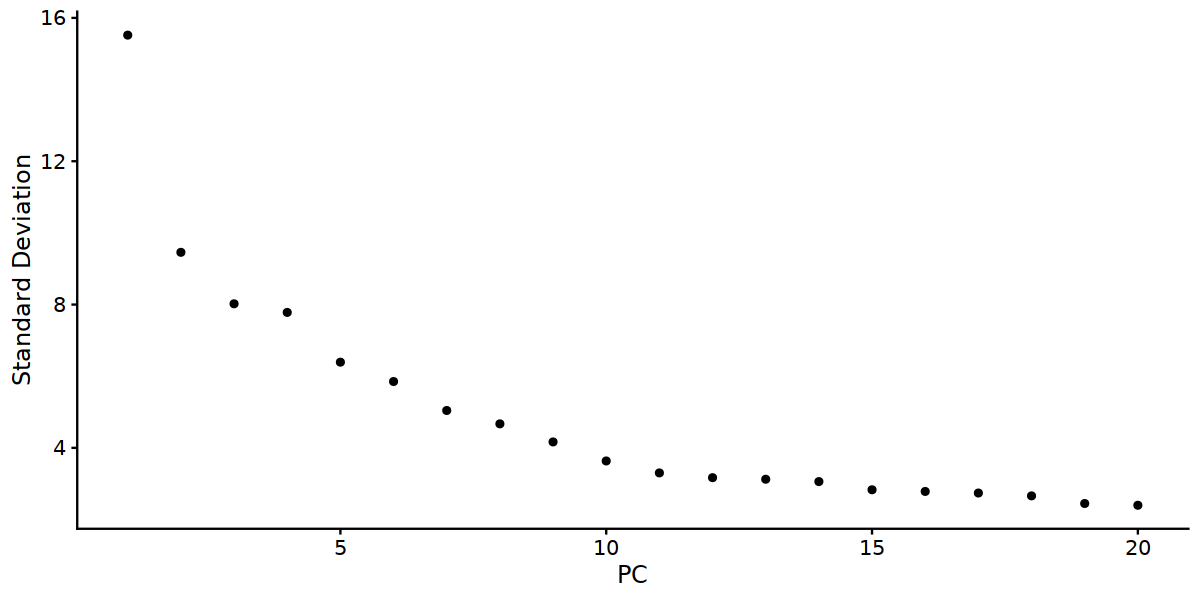

In [71]:
options(repr.plot.width=10, repr.plot.height=5)
ElbowPlot(rna_obj_p4)
rna_obj_p4

## Get RNA neighbor graph

In [72]:
# build a neighbor graph using SCT assay
DefaultAssay(rna_obj_p4) <- 'SCT'
rna_obj_p4 <- FindNeighbors(object = rna_obj_p4,
                                  reduction = 'pca',
                                  dims = 1:50,
                                  verbose = TRUE
                                  )

Computing nearest neighbor graph

Computing SNN



In [73]:
Graphs(rna_obj_p4)

[1] "SCT_nn"  "SCT_snn"

## Get RNA UMAP

In [74]:
rna_obj_p4 <- RunUMAP(
  object = rna_obj_p4,
  reduction = "pca", 
  dims = 1:50,
  reduction.name = "rna_only_UMAP",
  reduction.key = "rna_only_UMAP_",
  verbose = TRUE
)
     
# https://satijalab.org/seurat/articles/integration_introduction.html
# https://satijalab.org/seurat/reference/runumap


20:58:07 UMAP embedding parameters a = 0.9922 b = 1.112

20:58:07 Read 6804 rows and found 50 numeric columns

20:58:07 Using Annoy for neighbor search, n_neighbors = 30

20:58:07 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:58:07 Writing NN index file to temp file /tmp/RtmpAV3adY/fileb0d92c53b238

20:58:07 Searching Annoy index using 1 thread, search_k = 3000

20:58:09 Annoy recall = 100%

20:58:11 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

20:58:13 Initializing from normalized Laplacian + noise (using irlba)

20:58:13 Commencing optimization for 500 epochs, with 332522 positive edges

20:58:35 Optimization finished



## Clustering

In [75]:
rna_obj_p4 <- FindClusters(
  object = rna_obj_p4,
  algorithm = 3,
  resolution = 1.2,
  verbose = FALSE
)

rna_obj_p4

An object of class Seurat 
35536 features across 6804 samples within 2 assays 
Active assay: SCT (15824 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, rna_only_UMAP

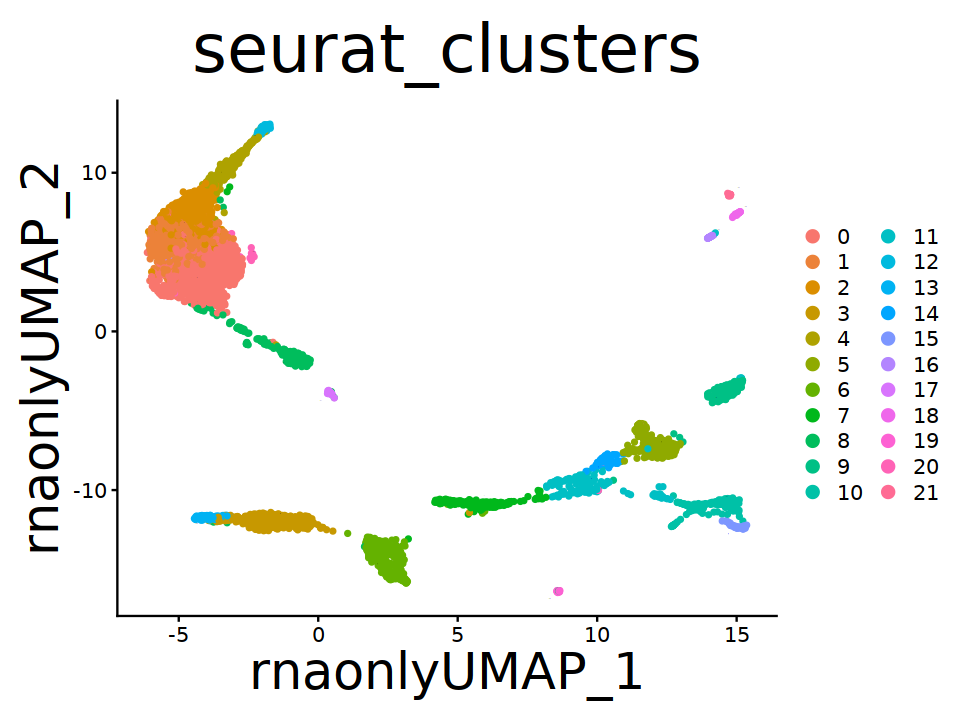

In [76]:
options(repr.plot.width=8, repr.plot.height=6)

DimPlot(rna_obj_p4, shuffle=TRUE, label = TRUE, repel = TRUE, pt.siz=1, label.size=0, reduction = "rna_only_UMAP", group.by = 'seurat_clusters', raster=FALSE) + theme(plot.title = element_text(size=40),
                                                                                                                                         axis.title = element_text(size=30)
                                                                                                                                        )
     

     

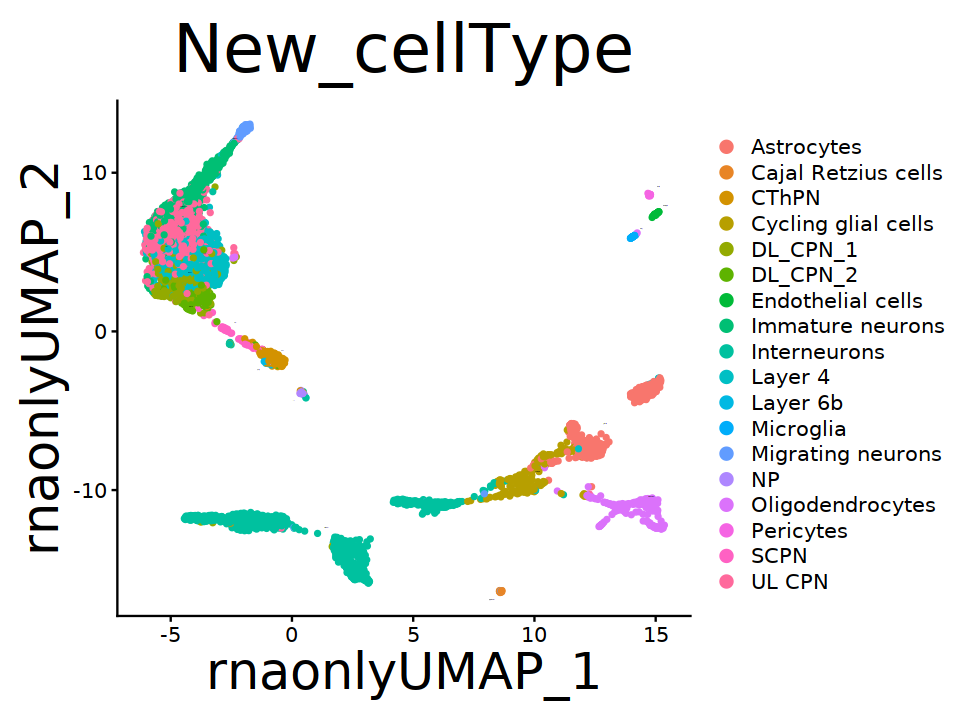

In [77]:
options(repr.plot.width=8, repr.plot.height=6)

DimPlot(rna_obj_p4, shuffle=TRUE, label = TRUE, repel = TRUE, pt.siz=1, label.size=0, reduction = "rna_only_UMAP", group.by = 'New_cellType', raster=FALSE) + theme(plot.title = element_text(size=40),
                                                                                                                                         axis.title = element_text(size=30)
                                                                                                                                        )
     

     

# Get ATAC gene activities

In [79]:
filtered

An object of class Seurat 
313874 features across 718 samples within 1 assay 
Active assay: peaks (313874 features, 313744 variable features)
 2 dimensional reductions calculated: lsi, umap

In [82]:
Annotation(filtered) <- annotation

In [83]:
# compute gene activities
gene.activities <- GeneActivity(filtered)

# add the gene activity matrix to the Seurat object as a new assay
filtered[['RNA']] <- CreateAssayObject(counts = gene.activities)
filtered <- NormalizeData(
  object = filtered,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(filtered$nCount_RNA)
)

Extracting gene coordinates

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions



In [84]:
filtered

An object of class Seurat 
335682 features across 718 samples within 2 assays 
Active assay: peaks (313874 features, 313744 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: lsi, umap

# Transfer labels to ATAC

In [85]:
DefaultAssay(rna_obj_p4) <- 'RNA'
rna_obj_p4 <- FindVariableFeatures(
  object = rna_obj_p4,
  nfeatures = 5000
)

rna_obj_p4

An object of class Seurat 
35536 features across 6804 samples within 2 assays 
Active assay: RNA (19712 features, 5000 variable features)
 1 other assay present: SCT
 2 dimensional reductions calculated: pca, rna_only_UMAP

In [86]:
DefaultAssay(rna_obj_p4) <- 'RNA'

transfer.anchors <- FindTransferAnchors(
  reference = rna_obj_p4,
  query.assay = 'RNA',
  query = filtered,
  reduction = 'cca',
  dims = 1:50
)


Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3588 anchors

Filtering anchors

	Retained 1492 anchors



In [87]:
predicted.labels <- TransferData(
  anchorset = transfer.anchors,
  refdata = rna_obj_p4$New_cellType,
  weight.reduction = filtered[['lsi']],
  dims = 2:30
)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [88]:
# add predicted labels to ATAC metadata

filtered <- AddMetaData(object = filtered, metadata = predicted.labels)

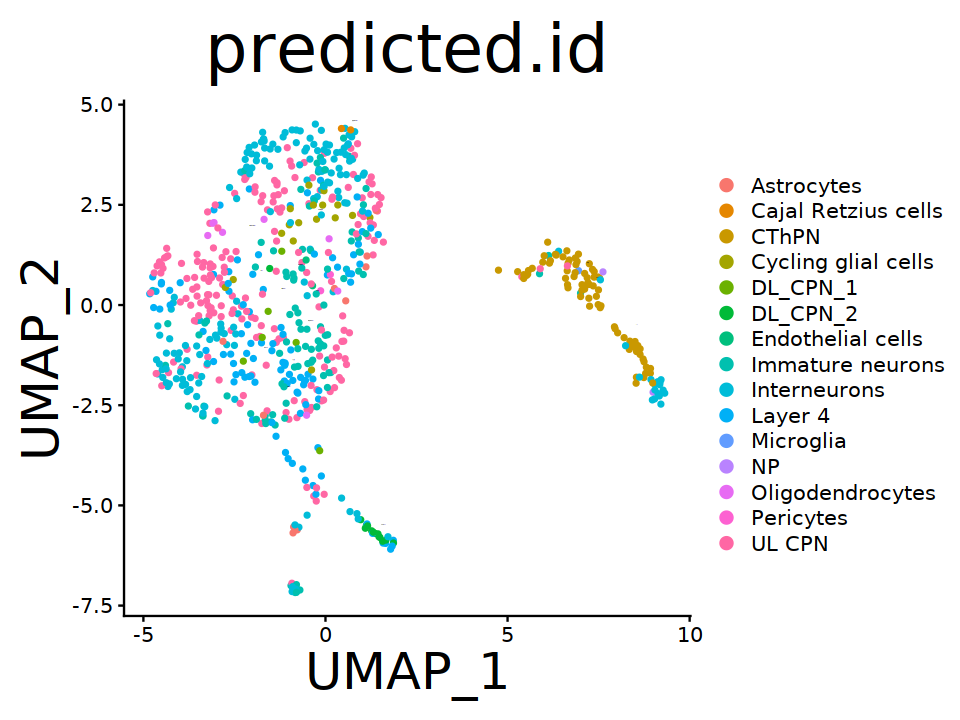

In [89]:
options(repr.plot.width=8, repr.plot.height=6)

DimPlot(filtered, shuffle=TRUE, label = TRUE, repel = TRUE, pt.siz=1, label.size=0, group.by = 'predicted.id', raster=FALSE) + theme(plot.title = element_text(size=40),
                                                                                                                                         axis.title = element_text(size=30)
                                                                                                                                        )
     

     

In [90]:
table(filtered$predicted.id)


         Astrocytes Cajal Retzius cells               CThPN Cycling glial cells 
                 12                   2                  78                  17 
           DL_CPN_1            DL_CPN_2   Endothelial cells    Immature neurons 
                  6                  14                   2                  94 
       Interneurons             Layer 4           Microglia                  NP 
                176                 106                   1                   2 
   Oligodendrocytes           Pericytes              UL CPN 
                  8                   2                 198 

# Save filtered, development-annotated ATAC object

### Change predicted.id column name (since doing Azimuth afterwards)

In [91]:
# sanity check
setequal(colnames(filtered@meta.data), names(filtered@meta.data))

[1] TRUE

In [92]:
colnames(filtered@meta.data)

[1] "orig.ident"                          
 [2] "nCount_peaks"                        
 [3] "nFeature_peaks"                      
 [4] "nCount_ATAC"                         
 [5] "nFeature_ATAC"                       
 [6] "total"                               
 [7] "duplicate"                           
 [8] "chimeric"                            
 [9] "unmapped"                            
[10] "lowmapq"                             
[11] "mitochondrial"                       
[12] "nonprimary"                          
[13] "passed_filters"                      
[14] "is__cell_barcode"                    
[15] "excluded_reason"                     
[16] "TSS_fragments"                       
[17] "DNase_sensitive_region_fragments"    
[18] "enhancer_region_fragments"           
[19] "promoter_region_fragments"           
[20] "on_target_fragments"                 
[21] "blacklist_region_fragments"          
[22] "peak_region_fragments"               
[23] "peak_region_cutsites"                
[24] "nucleosome_signal"                   
[25] "nucleosome_percentile"               
[26] "TSS.enrichment"                      
[27] "TSS.percentile"                      
[28] "pct_frags_in_peaks"                  
[29] "blacklist_ratio"                     
[30] "ATAC_snn_res.1.2"                    
[31] "seurat_clusters"                     
[32] "nCount_RNA"                          
[33] "nFeature_RNA"                        
[34] "predicted.id.dev"                    
[35] "prediction.score.Layer.4"            
[36] "prediction.score.Endothelial.cells"  
[37] "prediction.score.Astrocytes"         
[38] "prediction.score.Immature.neurons"   
[39] "prediction.score.UL.CPN"             
[40] "prediction.score.Interneurons"       
[41] "prediction.score.CThPN"              
[42] "prediction.score.DL_CPN_1"           
[43] "prediction.score.NP"                 
[44] "prediction.score.Oligodendrocytes"   
[45] "prediction.score.Cycling.glial.cells"
[46] "prediction.score.DL_CPN_2"           
[47] "prediction.score.SCPN"               
[48] "prediction.score.Migrating.neurons"  
[49] "prediction.score.Pericytes"          
[50] "prediction.score.Microglia"          
[51] "prediction.score.Cajal.Retzius.cells"
[52] "prediction.score.Layer.6b"           
[53] "prediction.score.max"                
[54] "predicted.id"                        
[55] "prediction.score.Lamp5"              
[56] "prediction.score.Sncg"               
[57] "prediction.score.Vip"                
[58] "prediction.score.Sst.Chodl"          
[59] "prediction.score.L2.IT.RHP"          
[60] "prediction.score.Sst"                
[61] "prediction.score.Pvalb"              
[62] "prediction.score.L2.3.IT.CTX.2"      
[63] "prediction.score.L4.5.IT.CTX"        
[64] "prediction.score.L5.IT.CTX"          
[65] "prediction.score.L5.PT.CTX"          
[66] "prediction.score.L5.NP.CTX"          
[67] "prediction.score.L6b.CTX"            
[68] "prediction.score.Car3"               
[69] "prediction.score.CR"                 
[70] "prediction.score.Oligo"              
[71] "prediction.score.Astro"              
[72] "prediction.score.SMC.Peri"           
[73] "prediction.score.Endo"               
[74] "prediction.score.VLMC"               
[75] "prediction.score.Micro.PVM"          
[76] "prediction.score.L6.IT.CTX"          
[77] "prediction.score.L6.CT.CTX"          
[78] "prediction.score.L2.3.IT.CTX.1"      
[79] "prediction.score.L3.RSP.ACA"         
[80] "prediction.score.L5.IT.TPE.ENT"      
[81] "prediction.score.L2.3.IT.PPP"        
[82] "peaks_snn_res.1.2"

In [93]:
# rename predicted.id
names(filtered@meta.data)[names(filtered@meta.data) == 'predicted.id'] <- 'predicted.id.dev'

# https://stackoverflow.com/questions/7531868/how-to-rename-a-single-column-in-a-data-frame

In [94]:
colnames(filtered@meta.data)

[1] "orig.ident"                          
 [2] "nCount_peaks"                        
 [3] "nFeature_peaks"                      
 [4] "nCount_ATAC"                         
 [5] "nFeature_ATAC"                       
 [6] "total"                               
 [7] "duplicate"                           
 [8] "chimeric"                            
 [9] "unmapped"                            
[10] "lowmapq"                             
[11] "mitochondrial"                       
[12] "nonprimary"                          
[13] "passed_filters"                      
[14] "is__cell_barcode"                    
[15] "excluded_reason"                     
[16] "TSS_fragments"                       
[17] "DNase_sensitive_region_fragments"    
[18] "enhancer_region_fragments"           
[19] "promoter_region_fragments"           
[20] "on_target_fragments"                 
[21] "blacklist_region_fragments"          
[22] "peak_region_fragments"               
[23] "peak_region_cutsites"                
[24] "nucleosome_signal"                   
[25] "nucleosome_percentile"               
[26] "TSS.enrichment"                      
[27] "TSS.percentile"                      
[28] "pct_frags_in_peaks"                  
[29] "blacklist_ratio"                     
[30] "ATAC_snn_res.1.2"                    
[31] "seurat_clusters"                     
[32] "nCount_RNA"                          
[33] "nFeature_RNA"                        
[34] "predicted.id.dev"                    
[35] "prediction.score.Layer.4"            
[36] "prediction.score.Endothelial.cells"  
[37] "prediction.score.Astrocytes"         
[38] "prediction.score.Immature.neurons"   
[39] "prediction.score.UL.CPN"             
[40] "prediction.score.Interneurons"       
[41] "prediction.score.CThPN"              
[42] "prediction.score.DL_CPN_1"           
[43] "prediction.score.NP"                 
[44] "prediction.score.Oligodendrocytes"   
[45] "prediction.score.Cycling.glial.cells"
[46] "prediction.score.DL_CPN_2"           
[47] "prediction.score.SCPN"               
[48] "prediction.score.Migrating.neurons"  
[49] "prediction.score.Pericytes"          
[50] "prediction.score.Microglia"          
[51] "prediction.score.Cajal.Retzius.cells"
[52] "prediction.score.Layer.6b"           
[53] "prediction.score.max"                
[54] "predicted.id.dev"                    
[55] "prediction.score.Lamp5"              
[56] "prediction.score.Sncg"               
[57] "prediction.score.Vip"                
[58] "prediction.score.Sst.Chodl"          
[59] "prediction.score.L2.IT.RHP"          
[60] "prediction.score.Sst"                
[61] "prediction.score.Pvalb"              
[62] "prediction.score.L2.3.IT.CTX.2"      
[63] "prediction.score.L4.5.IT.CTX"        
[64] "prediction.score.L5.IT.CTX"          
[65] "prediction.score.L5.PT.CTX"          
[66] "prediction.score.L5.NP.CTX"          
[67] "prediction.score.L6b.CTX"            
[68] "prediction.score.Car3"               
[69] "prediction.score.CR"                 
[70] "prediction.score.Oligo"              
[71] "prediction.score.Astro"              
[72] "prediction.score.SMC.Peri"           
[73] "prediction.score.Endo"               
[74] "prediction.score.VLMC"               
[75] "prediction.score.Micro.PVM"          
[76] "prediction.score.L6.IT.CTX"          
[77] "prediction.score.L6.CT.CTX"          
[78] "prediction.score.L2.3.IT.CTX.1"      
[79] "prediction.score.L3.RSP.ACA"         
[80] "prediction.score.L5.IT.TPE.ENT"      
[81] "prediction.score.L2.3.IT.PPP"        
[82] "peaks_snn_res.1.2"

### Save the object

In [95]:
save_path_filt_annot <- paste0(outdir, "/merged_annotated_objects/", sample, ".merged.filtered.dev.annotated.rds")

saveRDS(filtered, file = save_path_filt_annot)

In [96]:
print(save_path_filt_annot)

filtered

[1] "/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step2_merge_OUTPUTS/merged_annotated_objects/E2.merged.filtered.dev.annotated.rds"


An object of class Seurat 
335682 features across 718 samples within 2 assays 
Active assay: peaks (313874 features, 313744 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: lsi, umap

# Anchor to Azimuth

In [97]:
filtered

An object of class Seurat 
335682 features across 718 samples within 2 assays 
Active assay: peaks (313874 features, 313744 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: lsi, umap

### Load Allen Mouse Motor Cortex scRNA-seq rds object

In [98]:
mouse_motor_cortex_ref_path = '/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/allen_mousecortexref_data/allen_mop_2020.rds'
mouse_motor_cortex_ref_path

[1] "/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/allen_mousecortexref_data/allen_mop_2020.rds"

In [99]:
allen_motor_cortex_rna_rds <- readRDS(file = mouse_motor_cortex_ref_path)

allen_motor_cortex_rna_rds

An object of class Seurat 
31053 features across 5666 samples within 1 assay 
Active assay: RNA (31053 features, 0 variable features)

In [100]:
allen_motor_cortex_rna_rds@meta.data

,class,cluster,subclass,donor_sex,region,cortical_layer,external_donor_name,nCount_RNA,nFeature_RNA
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>
GACCTGGAGGAATGGA-L8TX_171026_01_F03,GABAergic,9_Lamp5,Lamp5,M,MOp,All,352353,14759,5238
GCAATCAAGTAATCCC-L8TX_171026_01_A05,GABAergic,9_Lamp5,Lamp5,M,MOp,All,352356,15335,5194
TCTTTCCTCATGTCCC-L8TX_171026_01_G05,GABAergic,9_Lamp5,Lamp5,M,MOp,All,352357,7463,3441
GCGAGAACACTCAGGC-L8TX_171026_01_F03,GABAergic,3_Lamp5 Lhx6,Lamp5,M,MOp,All,352353,8062,3511
TACACGATCCAGAAGG-L8TX_171026_01_D05,GABAergic,12_Lamp5,Lamp5,M,MOp,All,352357,7709,3448
CGCCAAGCAGAGCCAA-L8TX_171026_01_B05,GABAergic,25_Sncg,Sncg,M,MOp,All,352356,21139,5902
CGGACGTGTTGCTCCT-L8TX_171026_01_H04,GABAergic,25_Sncg,Sncg,M,MOp,All,352356,14388,4913
TACTCATCACTACAGT-L8TX_171026_01_G04,GABAergic,26_Sncg,Sncg,M,MOp,All,352356,25758,6260
GATCGATGTGACAAAT-L8TX_171026_01_B04,GABAergic,30_Sncg,Sncg,M,MOp,All,352353,32169,7030


In [101]:
table(allen_motor_cortex_rna_rds@meta.data$class)
table(allen_motor_cortex_rna_rds@meta.data$subclass)


    GABAergic Glutamatergic  Non-Neuronal 
         1800          3016           850 


        Astro          Car3            CR          Endo     L2 IT RHP 
          300           300            10           104             1 
L2/3 IT CTX-1 L2/3 IT CTX-2   L2/3 IT PPP    L3 RSP-ACA   L4/5 IT CTX 
          300           300             1             1           300 
    L5 IT CTX L5 IT TPE-ENT     L5 NP CTX     L5 PT CTX     L6 CT CTX 
          300             3           300           300           300 
    L6 IT CTX       L6b CTX         Lamp5     Micro-PVM         Oligo 
          300           300           300           111           300 
        Pvalb      SMC-Peri          Sncg           Sst     Sst Chodl 
          300            27           300           300           300 
          Vip          VLMC 
          300             8 

### Preprocess scRNA data

In [102]:
DefaultAssay(allen_motor_cortex_rna_rds) <- "RNA"
allen_motor_cortex_rna_rds <- SCTransform(allen_motor_cortex_rna_rds)
allen_motor_cortex_rna_rds <- RunPCA(allen_motor_cortex_rna_rds)

allen_motor_cortex_rna_rds

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21030 by 5666

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 119 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 21030 genes



  |======================================================================| 100%


Computing corrected count matrix for 21030 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.596219 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

PC_ 1 
Positive:  Meg3, Nrgn, Pcp4, Gm28928, Kcnip4, Lrrtm4, Camk2n1, Nrxn3, Galntl6, Rbfox1 
	   Cntnap2, Nrg3, Mgat4c, Hs3st4, Cdh18, Cck, Kcnq5, Mef2c, Pde1a, Lingo2 
	   Csmd1, Frmpd4, Ptprd, Gad1, Tenm2, Gad2, Fam19a1, Arpp21, Etl4, Grik1 
Negative:  Qk, Atp1a2, Slc1a3, Glul, Plpp3, Gpc5, Mt1, Apoe, Cst3, Ptprz1 
	   Mertk, S1pr1, Hepacam, Gja1, St3gal4, Prex2, Csrp1, Selenop, Luzp2, Slco1c1 
	   Maml2, Gpr37l1, Zbtb20, Tsc22d4, Lsamp, Mt2, Slc1a2, Mfge8, S100a16, Cdh19 
PC_ 2 
Positive:  Nrgn, Gm28928, Slc17a7, Camk2n1, Hs3st4, Ptprd, Fam19a1, Arpp21, 3110035E14Rik, C1ql3 
	   Nrn1, Sv2b, Slc1a2, Rasgrp1, Lmo4, Rgs4, Pcp4, Car10, Nptx1, Lingo1 
	   Ano3, Enc1, Prkcb, Satb2, Atp2b1, 1110008P14Rik, Baiap2, Celf2, Homer1, Egr1 
Negative:  Erbb4, Gad1, Gad2, Adarb2, Galntl6, Npas3, 

An object of class Seurat 
52083 features across 5666 samples within 2 assays 
Active assay: SCT (21030 features, 3000 variable features)
 1 other assay present: RNA
 1 dimensional reduction calculated: pca

An object of class Seurat 
52083 features across 5666 samples within 2 assays 
Active assay: SCT (21030 features, 3000 variable features)
 1 other assay present: RNA
 1 dimensional reduction calculated: pca

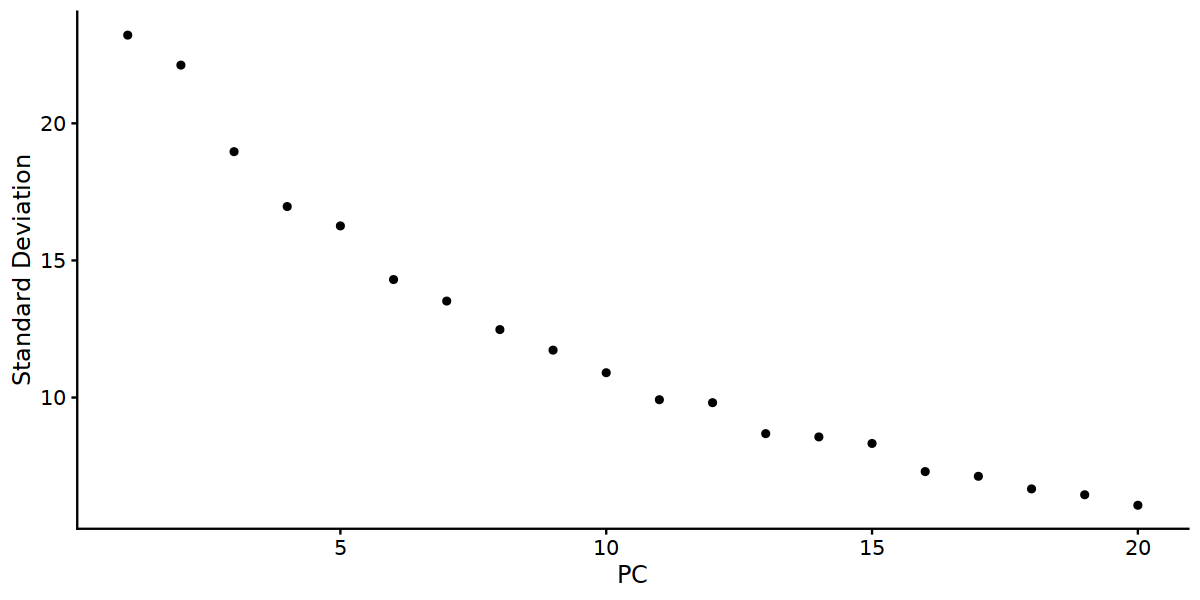

In [103]:
options(repr.plot.width=10, repr.plot.height=5)
ElbowPlot(allen_motor_cortex_rna_rds)
allen_motor_cortex_rna_rds

### Get RNA neighbor graph

In [104]:
# build a neighbor graph using SCT assay
DefaultAssay(allen_motor_cortex_rna_rds) <- 'SCT'
allen_motor_cortex_rna_rds <- FindNeighbors(object = allen_motor_cortex_rna_rds,
                                  reduction = 'pca',
                                  dims = 1:50,
                                  verbose = TRUE
                                  )

Computing nearest neighbor graph

Computing SNN



In [105]:
Graphs(allen_motor_cortex_rna_rds)

[1] "SCT_nn"  "SCT_snn"

### Get RNA UMAP

In [106]:
allen_motor_cortex_rna_rds <- RunUMAP(
  object = allen_motor_cortex_rna_rds,
  reduction = "pca", 
  dims = 1:50,
  reduction.name = "rna_only_UMAP",
  reduction.key = "rna_only_UMAP_",
  verbose = TRUE
)
     
# https://satijalab.org/seurat/articles/integration_introduction.html
# https://satijalab.org/seurat/reference/runumap


21:06:33 UMAP embedding parameters a = 0.9922 b = 1.112

21:06:33 Read 5666 rows and found 50 numeric columns

21:06:33 Using Annoy for neighbor search, n_neighbors = 30

21:06:33 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:06:34 Writing NN index file to temp file /tmp/RtmpAV3adY/fileb0d918bc082a

21:06:34 Searching Annoy index using 1 thread, search_k = 3000

21:06:35 Annoy recall = 100%

21:06:36 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

21:06:39 Found 4 connected components, 
falling back to 'spca' initialization with init_sdev = 1

21:06:39 Using 'irlba' for PCA

21:06:39 PCA: 2 components explained 26.43% variance

21:06:39 Scaling init to sdev = 1

21:06:39 Commencing optimization for 500 epochs, with 216828 p

## Clustering

In [107]:
allen_motor_cortex_rna_rds <- FindClusters(
  object = allen_motor_cortex_rna_rds,
  algorithm = 3,
  resolution = 1.2,
  verbose = FALSE
)

rna_obj_p4

An object of class Seurat 
35536 features across 6804 samples within 2 assays 
Active assay: RNA (19712 features, 5000 variable features)
 1 other assay present: SCT
 2 dimensional reductions calculated: pca, rna_only_UMAP

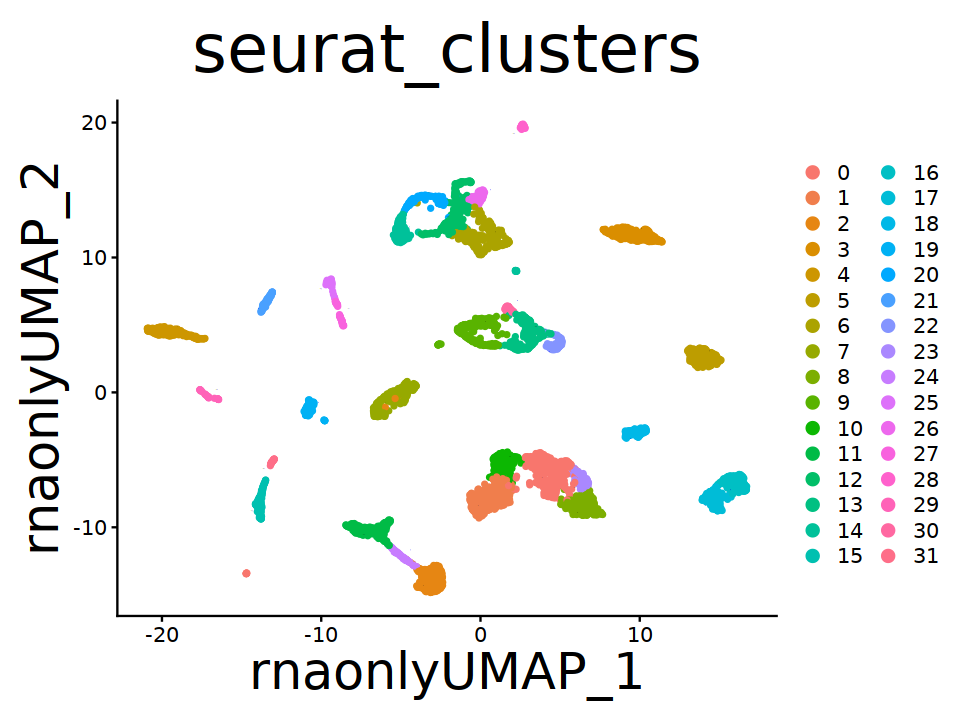

In [108]:
options(repr.plot.width=8, repr.plot.height=6)

DimPlot(allen_motor_cortex_rna_rds, shuffle=TRUE, label = TRUE, repel = TRUE, pt.siz=1, label.size=0, reduction = "rna_only_UMAP", group.by = 'seurat_clusters', raster=FALSE) + theme(plot.title = element_text(size=40),
                                                                                                                                         axis.title = element_text(size=30)
                                                                                                                                        )
     

     

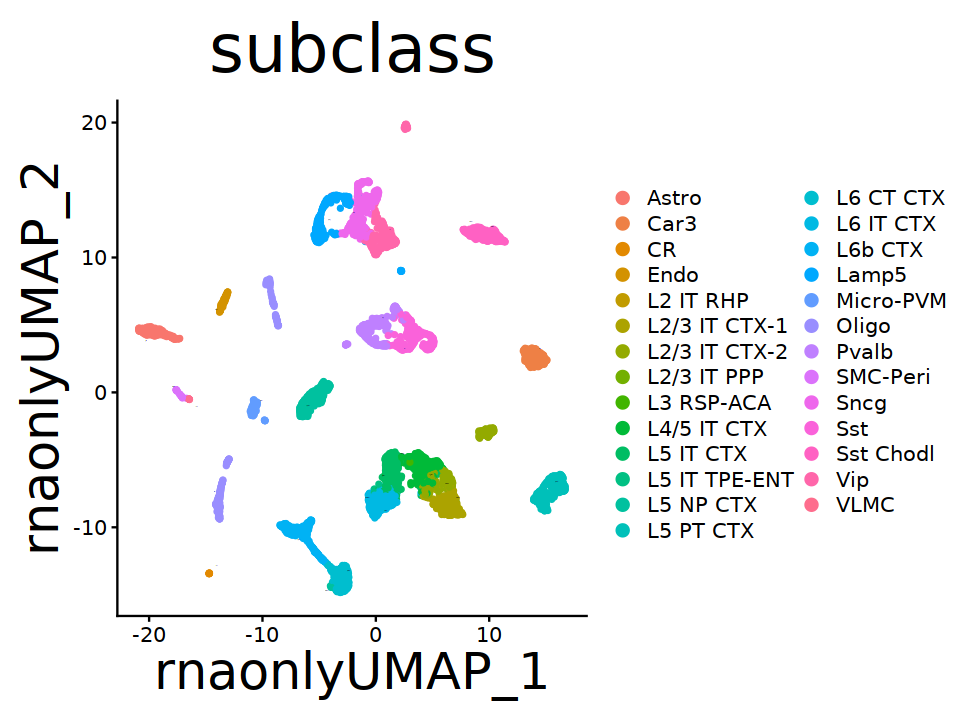

In [109]:
options(repr.plot.width=8, repr.plot.height=6)

DimPlot(allen_motor_cortex_rna_rds, shuffle=TRUE, label = TRUE, repel = TRUE, pt.siz=1, label.size=0, reduction = "rna_only_UMAP", group.by = 'subclass', raster=FALSE) + theme(plot.title = element_text(size=40),
                                                                                                                                         axis.title = element_text(size=30)
                                                                                                                                        )
     

     

# Transfer labels to ATAC

In [110]:
DefaultAssay(allen_motor_cortex_rna_rds) <- 'RNA'
allen_motor_cortex_rna_rds <- FindVariableFeatures(
  object = allen_motor_cortex_rna_rds,
  nfeatures = 5000
)

allen_motor_cortex_rna_rds

An object of class Seurat 
52083 features across 5666 samples within 2 assays 
Active assay: RNA (31053 features, 5000 variable features)
 1 other assay present: SCT
 2 dimensional reductions calculated: pca, rna_only_UMAP

In [111]:
DefaultAssay(allen_motor_cortex_rna_rds) <- 'RNA'

transfer.anchors.motor.cortex <- FindTransferAnchors(
  reference = allen_motor_cortex_rna_rds,
  query.assay = 'RNA',
  query = filtered,
  reduction = 'cca',
  dims = 1:50
)


Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3542 anchors

Filtering anchors

	Retained 1712 anchors



In [112]:
predicted.labels.motor.cortex <- TransferData(
  anchorset = transfer.anchors.motor.cortex,
  refdata = allen_motor_cortex_rna_rds$subclass,
  weight.reduction = filtered[['lsi']],
  dims = 2:30
)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [113]:
# add predicted labels to ATAC metadata

filtered <- AddMetaData(object = filtered, metadata = predicted.labels.motor.cortex)

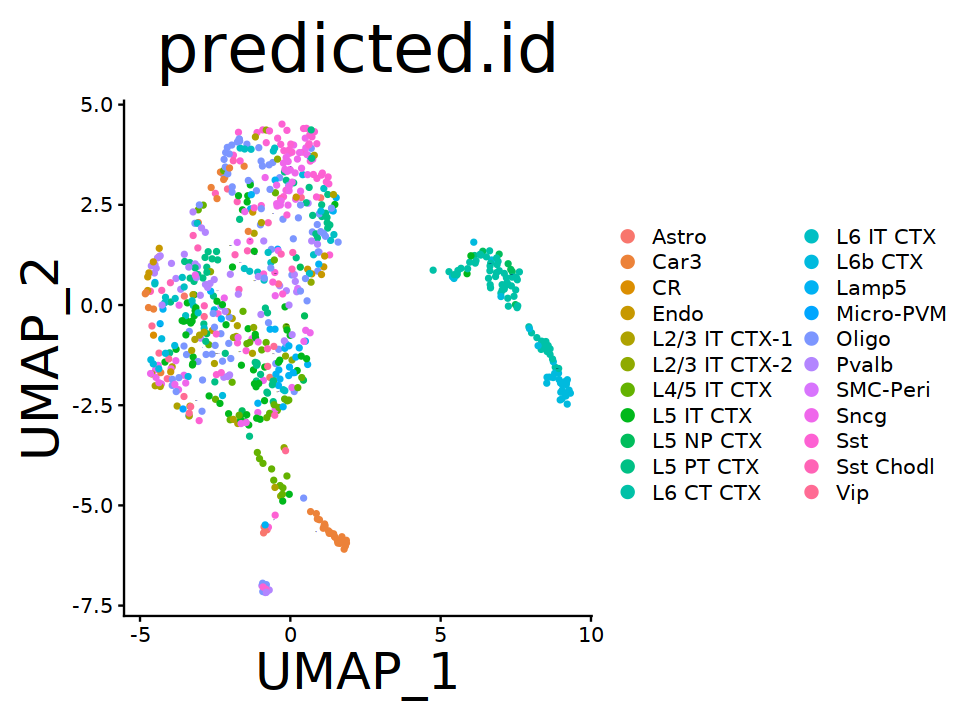

In [114]:
options(repr.plot.width=8, repr.plot.height=6)

DimPlot(filtered, shuffle=TRUE, label = TRUE, repel = TRUE, pt.siz=1, label.size=0, group.by = 'predicted.id', raster=FALSE) + theme(plot.title = element_text(size=40),
                                                                                                                                         axis.title = element_text(size=30)
                                                                                                                                        )
     

     

In [115]:
table(filtered$predicted.id)


        Astro          Car3            CR          Endo L2/3 IT CTX-1 
            8            39             1            14            26 
L2/3 IT CTX-2   L4/5 IT CTX     L5 IT CTX     L5 NP CTX     L5 PT CTX 
           10            36            60            11            55 
    L6 CT CTX     L6 IT CTX       L6b CTX         Lamp5     Micro-PVM 
           65            30            43            31             3 
        Oligo         Pvalb      SMC-Peri          Sncg           Sst 
           83            52             2            61            55 
    Sst Chodl           Vip 
           19            14 

In [116]:
colnames(filtered@meta.data)

[1] "orig.ident"                          
 [2] "nCount_peaks"                        
 [3] "nFeature_peaks"                      
 [4] "nCount_ATAC"                         
 [5] "nFeature_ATAC"                       
 [6] "total"                               
 [7] "duplicate"                           
 [8] "chimeric"                            
 [9] "unmapped"                            
[10] "lowmapq"                             
[11] "mitochondrial"                       
[12] "nonprimary"                          
[13] "passed_filters"                      
[14] "is__cell_barcode"                    
[15] "excluded_reason"                     
[16] "TSS_fragments"                       
[17] "DNase_sensitive_region_fragments"    
[18] "enhancer_region_fragments"           
[19] "promoter_region_fragments"           
[20] "on_target_fragments"                 
[21] "blacklist_region_fragments"          
[22] "peak_region_fragments"               
[23] "peak_region_cutsites"                
[24] "nucleosome_signal"                   
[25] "nucleosome_percentile"               
[26] "TSS.enrichment"                      
[27] "TSS.percentile"                      
[28] "pct_frags_in_peaks"                  
[29] "blacklist_ratio"                     
[30] "ATAC_snn_res.1.2"                    
[31] "seurat_clusters"                     
[32] "nCount_RNA"                          
[33] "nFeature_RNA"                        
[34] "predicted.id.dev"                    
[35] "prediction.score.Layer.4"            
[36] "prediction.score.Endothelial.cells"  
[37] "prediction.score.Astrocytes"         
[38] "prediction.score.Immature.neurons"   
[39] "prediction.score.UL.CPN"             
[40] "prediction.score.Interneurons"       
[41] "prediction.score.CThPN"              
[42] "prediction.score.DL_CPN_1"           
[43] "prediction.score.NP"                 
[44] "prediction.score.Oligodendrocytes"   
[45] "prediction.score.Cycling.glial.cells"
[46] "prediction.score.DL_CPN_2"           
[47] "prediction.score.SCPN"               
[48] "prediction.score.Migrating.neurons"  
[49] "prediction.score.Pericytes"          
[50] "prediction.score.Microglia"          
[51] "prediction.score.Cajal.Retzius.cells"
[52] "prediction.score.Layer.6b"           
[53] "prediction.score.max"                
[54] "predicted.id.dev.1"                  
[55] "prediction.score.Lamp5"              
[56] "prediction.score.Sncg"               
[57] "prediction.score.Vip"                
[58] "prediction.score.Sst.Chodl"          
[59] "prediction.score.L2.IT.RHP"          
[60] "prediction.score.Sst"                
[61] "prediction.score.Pvalb"              
[62] "prediction.score.L2.3.IT.CTX.2"      
[63] "prediction.score.L4.5.IT.CTX"        
[64] "prediction.score.L5.IT.CTX"          
[65] "prediction.score.L5.PT.CTX"          
[66] "prediction.score.L5.NP.CTX"          
[67] "prediction.score.L6b.CTX"            
[68] "prediction.score.Car3"               
[69] "prediction.score.CR"                 
[70] "prediction.score.Oligo"              
[71] "prediction.score.Astro"              
[72] "prediction.score.SMC.Peri"           
[73] "prediction.score.Endo"               
[74] "prediction.score.VLMC"               
[75] "prediction.score.Micro.PVM"          
[76] "prediction.score.L6.IT.CTX"          
[77] "prediction.score.L6.CT.CTX"          
[78] "prediction.score.L2.3.IT.CTX.1"      
[79] "prediction.score.L3.RSP.ACA"         
[80] "prediction.score.L5.IT.TPE.ENT"      
[81] "prediction.score.L2.3.IT.PPP"        
[82] "peaks_snn_res.1.2"                   
[83] "predicted.id"

### Old: using RunAzimuth()
I believe RunAzimuth() SCT-normalizes the ATAC gene activity matrix, which is not appropriate

In [117]:
# DefaultAssay(filtered) <- "RNA"    # ATAC gene activity
# filtered <- RunAzimuth(query = filtered, 
#                        assay = 'RNA',
#                        umap.name = 'azimuth.ref.umap',
#                        reference = "mousecortexref")
# filtered

# Save filtered, development- AND Azimuth-annotated ATAC object

In [118]:
save_path_filt_azimuth_annot <- paste0(outdir, "/merged_annotated_objects/", sample, ".merged.filtered.dev.azimuth.annotated.rds")

saveRDS(filtered, file = save_path_filt_azimuth_annot)

In [119]:
print(save_path_filt_azimuth_annot)

filtered

[1] "/oak/stanford/groups/tttt/users/xjluo/neurodev_collab/step2_merge_OUTPUTS/merged_annotated_objects/E2.merged.filtered.dev.azimuth.annotated.rds"


An object of class Seurat 
335682 features across 718 samples within 2 assays 
Active assay: peaks (313874 features, 313744 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: lsi, umap

# END